In [6]:
from crnn.models import crnn
from crnn.utils import load_conf
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path

In [2]:
class CTCLayer(keras.layers.Layer):
    """
    A dumb layer to calculate CTC loss and edit distance
    """
    def __call__(self, labels, logits, input_length, label_length):
        input_length = tf.cast(input_length, tf.int32)
        label_length = tf.cast(label_length, tf.int32)
        loss = keras.backend.ctc_batch_cost(
            labels, tf.nn.softmax(logits, axis=-1), input_length[:, tf.newaxis], label_length[:, tf.newaxis]
        )
        self.add_loss(tf.reduce_mean(loss))
        decoded, neg_sum_logits = tf.nn.ctc_greedy_decoder(tf.transpose(logits, [1, 0, 2]), sequence_length=input_length)
        label_sparse = keras.backend.ctc_label_dense_to_sparse(labels, label_length)
        edit_distance = tf.edit_distance(decoded[0], label_sparse)
        self.add_metric(tf.reduce_mean(edit_distance), name='edit_distance', aggregation='mean')
        return logits

In [3]:
conf = load_conf("./conf/crnn.yaml")
conf = conf['options']
conf

{'input_shape': [None, None, 3],
 'backbone': 'mobilev3_large_mini',
 'kernel_init': 'he_normal',
 'feature_layer': 'expanded_conv_11/Add',
 'n_class': 7550}

In [ ]:
def get_backbone(conf_path, input_tensor):
    """
    Create backbone network based on given config
    """
    conf = load_conf(str(conf_folder / (conf_path + ".yaml")))
    model = getattr(backbone, conf["name"])(**conf["options"], input_tensor=input_tensor)
    return model

In [22]:
image = keras.Input(shape=[64,224,3], name="image")
base = keras.applications.MobileNetV3Large(input_tensor=image)


In [61]:
feature = base.get_layer('expanded_conv_11/Add').output
print(feature)
logits_ori = keras.layers.SeparableConv2D(7550, kernel_size=(4, 1),
                                       strides=1, padding="valid",
                                       depthwise_initializer="he_normal")(feature)
print(logits_ori)
logits = keras.layers.Lambda(lambda x: tf.squeeze(x, 1), name='logits')(logits_ori)
# logits  = logits_ori
print(logits)

labels = keras.Input(shape=(None,), dtype=tf.int64, name='labels')
label_lengths = keras.Input(shape=(), dtype=tf.int64, name='label_lengths')
input_lengths = keras.Input(shape=(), dtype=tf.int64, name='input_lengths')
    
logits = CTCLayer()(labels, logits, input_lengths, label_lengths)
model = keras.Model(inputs=[base.input, labels, input_lengths, label_lengths], outputs=logits)

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 14, 112), dtype=tf.float32, name=None), name='expanded_conv_11/Add/add:0', description="created by layer 'expanded_conv_11/Add'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 14, 7550), dtype=tf.float32, name=None), name='separable_conv2d_30/BiasAdd:0', description="created by layer 'separable_conv2d_30'")
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 7550), dtype=tf.float32, name=None), name='logits/Squeeze:0', description="created by layer 'logits'")


In [59]:
# class Param:
#     def __init__(self,labels, logits, input_lengths, label_lengths):
#         self.labels = labels
#         self.logits = logits
#         self.input_lengths = input_lengths
#         self.label_lengths = label_lengths

# param = Param(labels, logits, input_lengths, label_lengths)
# for i in ('labels', 'logits', 'input_lengths', 'label_lengths'):
#     print(i,getattr(param,i))


labels KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int64, name='labels'), name='labels', description="created by layer 'labels'")
logits KerasTensor(type_spec=TensorSpec(shape=(None, 14, 7550), dtype=tf.float32, name=None), name='logits/Squeeze:0', description="created by layer 'logits'")
input_lengths KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int64, name='input_lengths'), name='input_lengths', description="created by layer 'input_lengths'")
label_lengths KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.int64, name='label_lengths'), name='label_lengths', description="created by layer 'label_lengths'")


In [55]:
param.logits

<KerasTensor: shape=(None, 14, 7550) dtype=float32 (created by layer 'logits')>

In [ ]:
model.summary()

In [ ]:
# workspace/dense.release/conf/mobilev3_large_mini.yaml
# conf_folder = Path('.').resolve().parent.parent / "conf"

base = get_backbone(conf["backbone"], input_tensor=image)
feature = base.get_layer(conf["feature_layer"]).output
logits_ori = keras.layers.SeparableConv2D(conf["n_class"], kernel_size=(4, 1),
                                   strides=1, padding="valid",
                                   depthwise_initializer=conf["kernel_init"])(feature)
logits = keras.layers.Lambda(lambda x: tf.squeeze(x, 1), name='logits')(logits_ori)

In [ ]:
keras.backend.clear_session()
model = crnn(conf["options"], train=False, infer_shape=(64, 1024, 3))

In [ ]:
model.summary()

In [ ]:
# model.save('./my_model.h5')
model.output

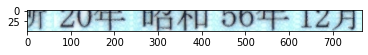

In [211]:
import matplotlib.pyplot as plt
import numpy as np
HEIGHT = 64.

img = tf.image.decode_jpeg(tf.io.read_file('/datasets/almex_insurance/combined_snow_elastic/972.jpg'),channels=3)
img_shape = tf.cast(tf.shape(img), tf.float32)
crop_max = 0.1
# crop_ratio = tf.random.uniform(()) * crop_max
crop_ratio = 1
crop_h = img_shape[0] / (1 + crop_ratio)
crop_w = tf.cast(img_shape[1], tf.int32) - tf.cast(crop_h * crop_ratio, tf.int32)
crop_h = tf.cast(crop_h, tf.int32)
img = tf.image.random_crop(img, (crop_h, crop_w, 3))
# img = tf.image.random_flip_left_right(img)
img_shape = tf.cast(tf.shape(img), tf.float32)
# w = tf.cast(HEIGHT / img_shape[0] * img_shape[1], tf.int64)
# img = tf.image.resize(img, (int(HEIGHT), w), method=tf.image.ResizeMethod.AREA)
plt.imshow(img.numpy().astype(np.int))

In [182]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.44277966>

In [ ]:
img = tf.image.random_crop(img, (crop_h, crop_w, 3))